# Logistic Regression from Scratch
Last week we used logistic regression to build our first brain signal decoder. Recall that the logistic model takes a measurement and determines the probability that it is associated with a binary outcome. In our case, we found that the degree of match between the EEG waveform and the average evoked response to a stimulus predicted whether a stimulus had been presented. We fit the logistic model using the scikit-learn package, but this masks much of what is going on 'under-the-hood' when it comes to fitting. The best way to learn about this is to code it ourselves, and in the process we will get a few side benefits. 
1. It will introduce us to more theoretical aspects of *optimization*, such as convex functions and gradient descent. These topics are broadly applicable across the machine learning field. 
2. The logistic model itself can be thought of as a single computational unit in a larger neural network, so a deep understanding of how it operates will help demystify more complex neural network models that you cover in other courses. 
3. This knowledge will set us up for adding additional complexity to our logistic decoder. In subsequent lectures we will cover how to use logisitic decoders with multiple inputs, and pool multiple decoders together to decode multiple categories of events.

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

## The problem

We have to find the parameters that best describe the relationship between neural features and the trial class. The space of possible parameters is infinite, and we want an approach to find them that is general enough to work with any data set we throw at it. One way is to randomly guess the parameters, and to keep guessing until we get a good fit. Here are some random guesses:


In [3]:
# load data from last week
data_dir = '../Week4/data/'

# load data
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))

# load fitted parameters
params = json.load(open(os.path.join(data_dir, 'model_params.json'), 'r'))

In [4]:
# get the model parameters fitted by sklearn
w_sk = params['coef']
b_sk = params['intercept']

print('Sklearn model parameters:')
print('w =', w_sk)
print('b =', b_sk)

Sklearn model parameters:
w = 0.05187913417506095
b = -1.8628904500466834


In [5]:
def logistic(x, w, b):
    return 1 / (1 + np.exp(-(w*x + b)))

def plot_logistic(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(X_vals, y_vals, alpha=0.5)
    x = np.linspace(np.min(X_vals), np.max(X_vals), 100)
    ax.plot(x, logistic(x, w, b), 'r')
    ax.grid()
    return ax

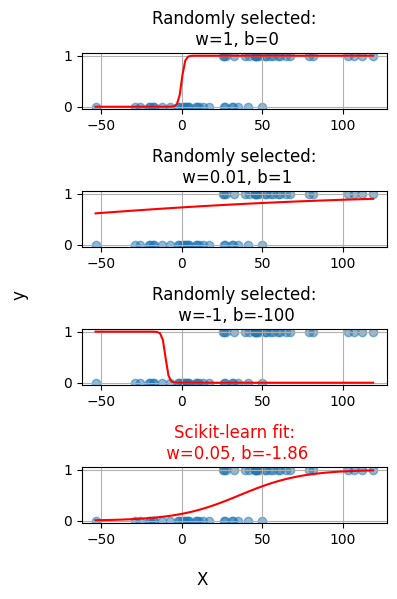

In [6]:
fig, ax = plt.subplots(4,1, figsize=(4,6))

plot_logistic(X, y, 1, 0, ax=ax[0])
ax[0].set_title('Randomly selected:\n w=1, b=0')
plot_logistic(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('Randomly selected:\n w=0.01, b=1')
plot_logistic(X, y, -1, -10, ax=ax[2])
ax[2].set_title('Randomly selected:\n w=-1, b=-100')
plot_logistic(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}'.format(w_sk, b_sk),color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Those random guesses don't look too good! While it may be tempting to keep trying different combinations of `w` and `b` to get a better fit, that would be a poor use of our time. Moreover, we would have to go through the same process for each new data set.

Instead, perhaps we could start with a random choice, and then iteratively update our parameters to try and get a better fit. At each update, we want to move the parameters so the fit gets better. This process is called optimization. For this to work, we need two things: a measure of the fit (referred to as a *loss function*), and a method for minimizing the loss function (we will use *gradient descent*). Let's discuss each of these in turn.

## Loss function
The loss function reflects the difference between the actual class, $y$, and the predicted probability of that class,  $\hat{y}$. The lower value it has, the better the fit. To start building this function, let's consider the probability of $y$ given our prediction, $\hat{y}$, expressed as $p(y|\hat{y})$. Since $y$ is a binary variable (i.e. Cue or NoCue), we can express the probability as a Bernoulli distribution:

$$ p(y|\hat{y}) = \hat{y}^y(1-\hat{y})^{1-y} \tag{1}$$

Note that if $y=1$, we just return $\hat{y}$, because:

$$ \begin{align} 
    \notag p(1|\hat{y}) &= \hat{y}^1(1-\hat{y})^{1-1}  \\
    \notag &= \hat{y}^1(1-\hat{y})^{0} \\ 
    \notag &= \hat{y}^1\times 1 \\
    \notag &= \hat{y}
    \end{align}
$$


and if $y=0$, then $1-\hat{y}$ is returned:
$$ \begin{align} 
    \notag p(0|\hat{y}) &= \hat{y}^0(1-\hat{y})^{1-0}  \\
    \notag &= 1\times(1-\hat{y})^{1} \\ 
    \notag &= 1-\hat{y}
    \end{align}
$$

Alternatively, it might make more sense to you if we express equation 1 as a piecewise function.
$$ p(y|\hat{y})=\begin{cases}
    \hat{y} & y=1 \\
    1-\hat{y} & y=0
    \end{cases}
$$

Each possiblity is represented as a different case enclosed by the large bracket. Here y=1 when a cue occurs, and y=0 when no cue is present. If a cue occured, then we return the probability of the cue, $\hat{y}$. If no cue occured, then we return the probability that no cue occured, $1-\hat{y}$. 

How does equation 1 behave depending on $y$ and $\hat{y}$?

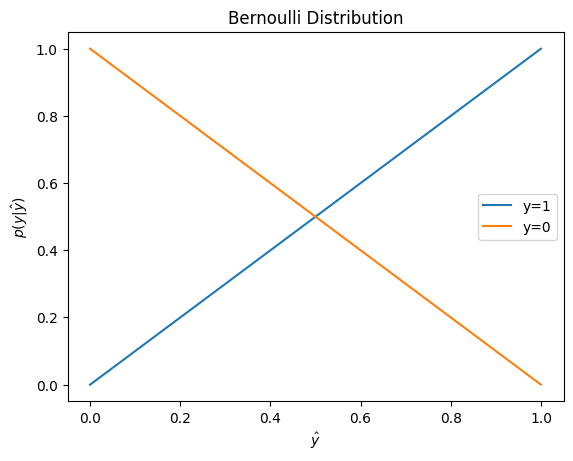

In [7]:
# method for calculating Bernoulli distribution
def bernoulli_dist(y, y_hat):
    return np.power(y_hat, y) * np.power(1-y_hat,1-y)

# array of potential y_hat values, probabilities range from 0 to 1
y_hat = np.linspace(0, 1, 100)

# plot the Bernoulli distribution for y=1 and y=0
fig, ax = plt.subplots()
ax.plot(y_hat, bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$p(y|\hat{y})$')
ax.set_title('Bernoulli Distribution')
ax.legend()
plt.show()

Using the Bernoulli distribution, if we fit a model successfully so that it correctly predicts $y$, then trials with a cue ($y=1$) will return high values of $\hat{y}$. Correctly predicting no cue ($y=0$), will give high values as well since $1-\hat{y}$ is returned. Performing this calculation for each pair of predicted and actual values, we can sum those together and evaluate the overall performance of our model. Put another way, a model with good performance will on average give larger values for $p(y|\hat{y})$. We can use this to compare the random model fits above. 

To visualize this, we can add arrows to our logistic regression graph that represent the output of the Bernoulli probability function for each sample.

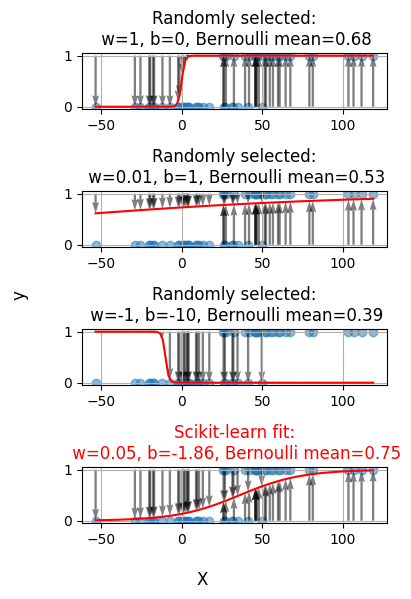

In [8]:
# method to plot the logistic model, 
# corresponding Bernoulli distribution values for each data point, 
# and the mean of the Bernoulli distribution values
def plot_logistic_bern(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax = plot_logistic(X_vals, y_vals, w, b, ax=ax)

    sign_y = np.sign(y_vals - 0.5)

    bern_vals = bernoulli_dist(y_vals, logistic(X_vals.squeeze(), w, b))
    ax.quiver(X_vals, 1-y_vals, np.zeros(y_vals.size), 
              sign_y*bern_vals, angles='xy', scale_units='xy', scale=1, alpha=0.5)
    return ax, np.mean(bern_vals)

fig, ax = plt.subplots(4,1, figsize=(4,6))

_, bern_sum = plot_logistic_bern(X, y, 1, 0, ax=ax[0])
ax[0].set_title('Randomly selected:\n w=1, b=0, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_bern(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('Randomly selected:\n w=0.01, b=1, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_bern(X, y, -1, -10, ax=ax[2])
ax[2].set_title('Randomly selected:\n w=-1, b=-10, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_bern(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, Bernoulli mean={:.2f}'.format(w_sk, b_sk, bern_sum), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()


Each datapoint has a black arrow pointing at it whose length is the Bernoulli distribution value for that particular observation. Longer arrows indicate a better match between the predicted and actual class. The top example has a high mean probability. This is because it has more of its Cue trials on the high probability side, and NoCue trials on the low probability side. The second example is similar, but the logistic function is so broad that the expected probabilities, $\hat{y}$, are never close to 0 or 1. Worst is the third example, whose sign is flipped with peak probability predicted for low x-values that is only summing probabilities for NoCue trials. Lastly, the fitted parameters derived from the scikit-learn logisitic regression object have the highest, and best, mean probability.

The behavior of the Bernoulli probability function makes it a good basis for constructing our loss function. To make it an actual loss function, we will make two changes. First, we will take its logarithm. This has several benefits. For now, we will just note that it changes the shape of the probability curves to give stronger weight to mismatches between the predicted and actual classes. Put another way, wrong answers are penalized more than correct ones. Second, we negate it so that lower values correspond to better fits. This is because the process we use for optimization is *gradient* __*descent*__, which tries to minimize the loss function. Semantically this makes sense, a smaller loss value should correspond to a better fit. So how does our loss function look?

$$ \begin{align}
    \notag -\log(p(y|\hat{y})) &= -\log(\hat{y}^y(1-\hat{y})^{1-y}) \\
    \notag &= -(y\log(\hat{y}) + (1-y)\log(1-\hat{y})) \\
    \end{align}
$$ 
(If you cannot follow the algebra here, see the bottom for rules for working with logarithms)

This loss function is referred to as the cross-entropy loss and is used in many machine learning applications that perform binary classification besides just logistic regression.


/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_8798/1054478998.py:3: RuntimeWarning: divide by zero encountered in log
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_8798/1054478998.py:3: RuntimeWarning: invalid value encountered in multiply
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


Text(0.5, 1.05, 'Cross-entropy loss')

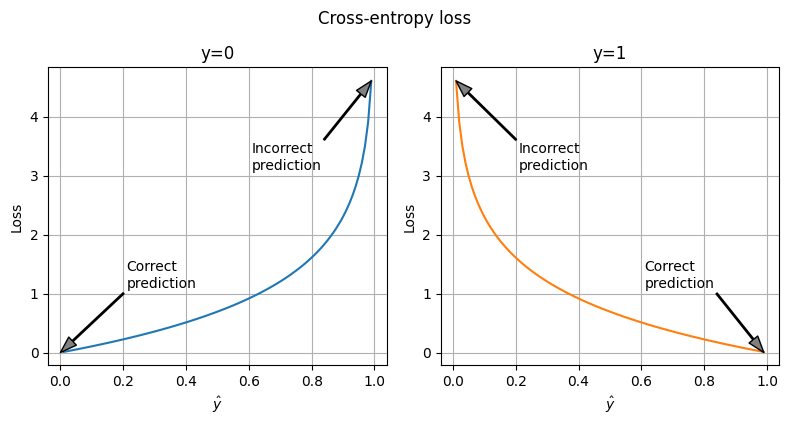

In [9]:
# cross entropy loss function
def cross_entropy(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


# plot comparison of Bernoulli and cross-entropy loss
# note we start at 0.01 to avoid log(0), which is undefined
x = np.linspace(0.01, 1, 100)

fig, ax = plt.subplots(1,2, figsize=(8,4))
# plot the cross-entropy loss when y=0
ax[0].plot(x, cross_entropy(0, x), color='tab:blue')
ax[0].set_title('y=0')
ax[0].grid()
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_ylabel('Loss')
ax[0].annotate('Correct\nprediction', xy=(0, 0), xytext=(0.21, 1.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))
ax[0].annotate('Incorrect\nprediction', xy=(0.99, cross_entropy(0,0.99)), xytext=(0.61, 3.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))

# plot the cross-entropy loss when y=1
ax[1].plot(x, cross_entropy(1, x), color='tab:orange')
ax[1].set_title('y=1')
ax[1].grid()
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_ylabel('Loss')
ax[1].annotate('Incorrect\nprediction', xy=(0.01, cross_entropy(0,0.99)), xytext=(0.21, 3.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))
ax[1].annotate('Correct\nprediction', xy=(0.99, 0), xytext=(0.61, 1.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))

fig.tight_layout()
fig.suptitle('Cross-entropy loss', y=1.05)

Here we can see that the cross-entropy loss function has the desired properties. It is larger the more incorrect our probability is (e.g. $y=0$ has largest loss when $\hat{y}=1$). As the predicted probability approaches the true probability, the loss approaches 0, reaching it when our prediction is correct. This is the case for both types of outcomes, 0 or 1, or in our specific case Cue or NoCue.

The cross-entropy loss function as written above only applies to a single sample. However, when fitting the logistic regression we have to minimize the loss across multiple samples. We can do this by taking the mean of the cross-entropy loss across samples like so:

$$ loss = -\frac{1}{N}\sum_{i=0}^{N}y_{i}\log(\hat{y}_{i}) + (1-y_{i})\log(1-\hat{y}_{i}) \tag{2}$$

Here $i$ refers to a sample and we have $N$ total samples in our data set. Translating this into code we get:

In [10]:
# Version of the cross entropy loss function that explicitly shows the mean calculation
def cross_entropy_loss_verbose(y, y_hat):
    # y is an array of 0s and 1s
    # y_hat is an array of probabilities
    
    N = y.size
    loss = 0
    for i in range(N):
        loss += -(y[i]*np.log(y_hat[i])+ (1-y[i])*np.log(1-y_hat[i]))

    return loss/N

# Version of the cross entropy loss function that uses numpy mean
def cross_entropy_loss(y, y_hat):
    # y is an array of 0s and 1s
    # y_hat is an array of probabilities
    
    return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))

Now that we can calculate the loss, we can see what value it takes for each of our guesses for the logistic regression parameters, and for the one returned by scikit-learn.

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_8798/440333998.py:18: RuntimeWarning: divide by zero encountered in log
  return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_8798/440333998.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))


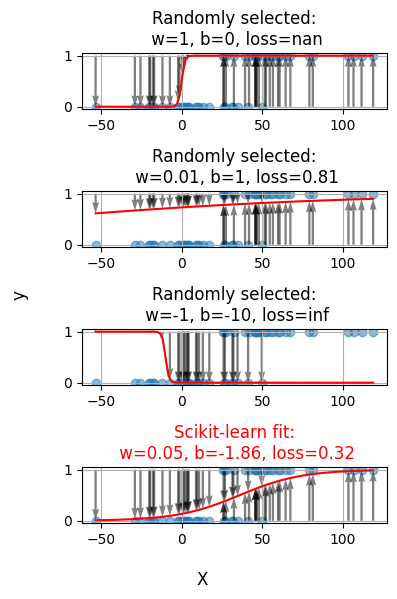

In [11]:
# Plot the cross-entropy loss for each set of model parameters
fig, ax = plt.subplots(4,1, figsize=(4,6))
plot_logistic_bern(X, y, 1, 0, ax=ax[0])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 1, 0))
ax[0].set_title('Randomly selected:\n w=1, b=0, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, 0.01, 1, ax=ax[1])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 0.01, 1))
ax[1].set_title('Randomly selected:\n w=0.01, b=1, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, -1, -10, ax=ax[2])
loss = cross_entropy_loss(y, logistic(X.squeeze(), -1, -10))
ax[2].set_title('Randomly selected:\n w=-1, b=-10, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, params['coef'], params['intercept'], ax=ax[3])
loss = cross_entropy_loss(y, logistic(X.squeeze(), params['coef'], params['intercept']))
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, loss={:.2f}'.format(params['coef'], params['intercept'], loss), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Uh oh, we can already see some problems here. The first and third guesses give a loss of 'nan' and 'inf', respectively. These likely reflect instances where a 0 is passed to `np.log`, which returns -infinity. To address this problem, we can set all instances of `y_hat` equal to 0 to the smallest possible floating point value, and `'y_hat` equal to 1 to its closest value.

In [12]:
# Fixed version of the cross entropy loss function that uses numpy mean
def cross_entropy_loss(y, y_hat):
    # y is an array of 0s and 1s
    # y_hat is an array of probabilities
    
    y_hat[y_hat==0] = np.finfo(float).eps # replace 0s with machine epsilon, the smallest possible floating point number
    y_hat[y_hat==1] = 1-np.finfo(float).eps # replace 1s with 1 minus machine epsilon
    return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))

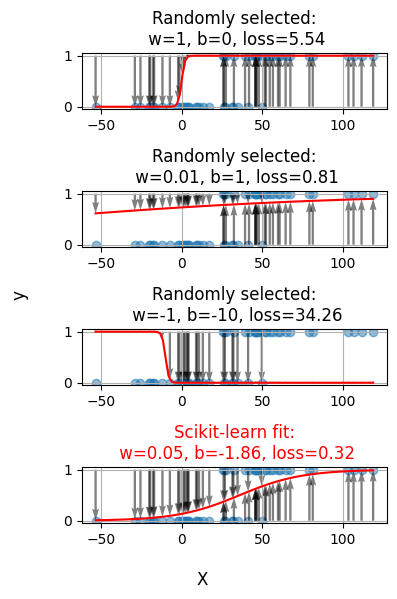

In [13]:
# Plot the fixed version of the cross-entropy loss for each set of parameters
fig, ax = plt.subplots(4,1, figsize=(4,6))
plot_logistic_bern(X, y, 1, 0, ax=ax[0])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 1, 0))
ax[0].set_title('Randomly selected:\n w=1, b=0, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, 0.01, 1, ax=ax[1])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 0.01, 1))
ax[1].set_title('Randomly selected:\n w=0.01, b=1, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, -1, -10, ax=ax[2])
loss = cross_entropy_loss(y, logistic(X.squeeze(), -1, -10))
ax[2].set_title('Randomly selected:\n w=-1, b=-10, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, params['coef'], params['intercept'], ax=ax[3])
loss = cross_entropy_loss(y, logistic(X.squeeze(), params['coef'], params['intercept']))
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, loss={:.2f}'.format(params['coef'], params['intercept'], loss), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Much better! It is not surpising that the cases with the largest loss were the ones previously undefined. They were most likely to have predicted probabilities returned that were closest to 0 or 1 since most datapoints fell on portions of the logisitic equation close to its asymptotes.

To summarize, the cross-entropy loss captures the degree to which the predicted probability of an event matches agrees with whether that event did or did not occur. Larger values indicate worse predictions, while smaller values suggest better predictions. We calculate this across all samples in our data and return the their mean, giving an assessment of the overall performance of our logistic decoder.

## Gradient descent

Now that we have a function that captures the performance of our logistic model, we want to find the combination of $w$ and $b$ parameters that miminize the cross-entropy loss. Scikit-learn offers several different approaches, but all of these are essentially engaging in some form of gradient descent. Indeed, virtually all neural networks are trained via some form of gradient descent procedure. Thus, what we cover here will apply broadly.

To start off, let's consider how gradient descent works with a toy example. Imagine we have a loss function of the form:
$$loss(x) = x^2$$
This is a quadratic function, where $x$ is the parameter that we seek to change to minimize the value of our loss, $x^2$. We can imagine that $loss(x)$ is a surface, we start exploring that surface by choosing a random value of $x$ that we will be our starting position.

Starting point: -3.8651152810635048


Text(0.5, 1.0, 'Toy loss function')

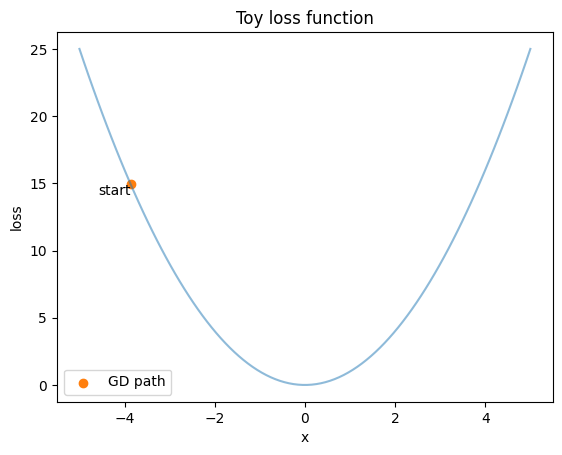

In [14]:
# toy loss function
def toy_loss(x):
    return x**2

# method to plot the landscape of the toy loss function
def plot_loss(ax=None, loss=toy_loss):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(-5, 5, 100)
    
    loss = loss(x)
    ax.plot(x, loss, color='tab:blue', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('loss')
    return ax

# method to plot the path of gradient descent on the toy loss function
def plot_loss_gd(ax=None, loss=toy_loss, x_pts=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if x_pts is not None:
        # plot points using linked arrows, using matplotlib with the start and end points labeled
        ax.quiver(x_pts[:-1], loss(x_pts[:-1]), np.diff(x_pts), np.diff(loss(x_pts)), 
                  angles='xy', scale_units='xy', scale=1, alpha=0.5, color='tab:orange', width=0.005)
        ax.scatter(x_pts, loss(x_pts), color='tab:orange', label='GD path')
        ax.text(x_pts[0], loss(x_pts[0]), 'start', ha='right', va='top')
        if x_pts.size > 1:
            ax.text(x_pts[-1], loss(x_pts[-1]), 'end', ha='left', va='bottom')
        ax.legend()
    
    return ax

# initialize random seed numpy
np.random.seed(47)

# choose our starting point at random
x_hist = np.random.uniform(-5, 5, 1)
print('Starting point:', x_hist[0])
ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')

Here the blue line is the loss landscape, a typical quadratic function with a minimum at $x=0$. We have chosen a random start point that is denoted by an orange dot. Our starting point is at $x=-3.86$, which is not at the minimum.

To get closer to the minimum, we can measure the slope of the loss landscape at our starting point, and then move our dot a little in the direction where that slope is descending. To get that slope, we need the derivative of our loss function, which is $2x$ (solved using the derivative power rule $\frac{d}{dx}x^n=nx^{n-1}$).

Let's code this now:

Text(0.5, 1.0, 'Toy loss function')

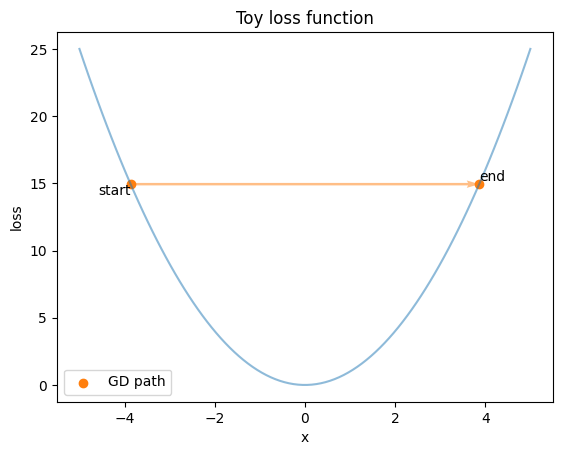

In [15]:
# calculate toy loss derivative
def toy_loss_derivative(x):
    return 2*x

# gradient descent step method
def gd_step(x, d_loss=toy_loss_derivative):
    return x - d_loss(x)

# run gradient descent for 1
x_hist = np.append(x_hist, gd_step(x_hist[-1]))

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')

Oh no, we moved our dot in the right direction, towards $x=0$, but proceeded to go too far and are now on the other side of the quadratic function. We may want to slow down how fast we are moving our dot so that we minimize the risk of overshooting. For that, we will add an additional argument to our `gd_step` function, `lr`, which stands for *learning rate*. 

Text(0.5, 1.0, 'Toy loss function')

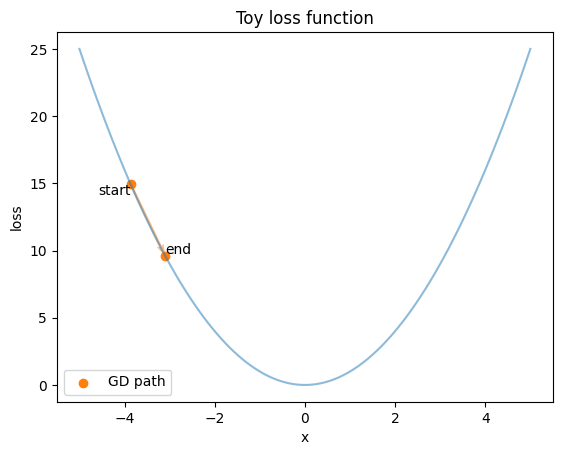

In [16]:
# undo the last, ill-advised step
x_hist = x_hist[:-1]

# gradient descent step method
def gd_step(x, d_loss=toy_loss_derivative, lr=0.1):
    return x - lr*d_loss(x)

# run gradient descent for 1
x_hist = np.append(x_hist, gd_step(x_hist[-1]))

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')

Much better. We have moved closer to the minimum of our loss function, and without overshooting it. Let's keep going for several more iterations.

Text(0.5, 1.0, 'Toy loss function')

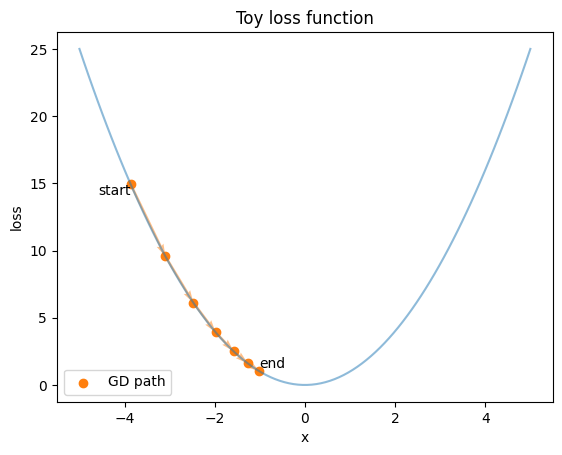

In [17]:
# run gradient descent for 5 more steps
for i in range(5):
    x_hist = np.append(x_hist, gd_step(x_hist[-1]))

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')


After 6 iterations we are closer to the bottom, but still not quite there. Note that the loss changes less and less as we get closer to the  Instead of trying to guess how many iterations are required, we could keep running the gradient descent process until the changes in the loss fall below a predetermined level, known as a *tolerance*. Here is how we can code that:

In [18]:
# incorporate a stopping criterion into the gradient descent step method
def gd_run(x, d_loss=toy_loss_derivative, lr=0.1, tol=0.01, max_iter=100):
    # x is the starting point, so we initialize the history with it
    x_hist = [x]

    # run gradient descent until the stopping criterion is met
    # or until we reach the maximum number of iterations
    for i in range(max_iter):
        # calculate the next step
        x_new = gd_step(x_hist[-1], d_loss=d_loss, lr=lr)
        x_hist.append(x_new)

        # check if the stopping criterion is met
        # if so, break out of the loop
        if np.abs(x_new - x_hist[-2]) < tol:
            break
    
    # return the history of x values and the number of iterations
    return np.array(x_hist).ravel(), i+1

This method automates our calls to the `gd_step` function. Given a starting point specified by `x`, and a learning rate (`lr`), it will iteratively run `gd_step` until either our loss is below tolerance (`tol`) or maximum number of iterations is reached (`max_iter`).  

Text(0.5, 1.0, 'Toy loss function\nLearning rate = 0.1\nIterations = 21')

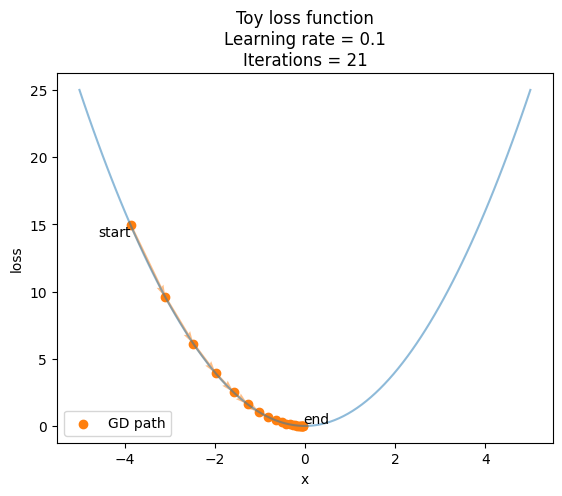

In [19]:
np.random.seed(47)
x_init = np.random.uniform(-5, 5, 1)

# run gradient descent with a learning rate of 0.1
x_hist, n_iter = gd_run(x_init, lr=0.1)

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function\nLearning rate = 0.1\nIterations = {}'.format(n_iter))


Just for fun, let's increase the learning rate and see if we can reach the minimum faster.

Text(0.5, 1.0, 'Toy loss function\nLearning rate = 0.8\nIterations = 14')

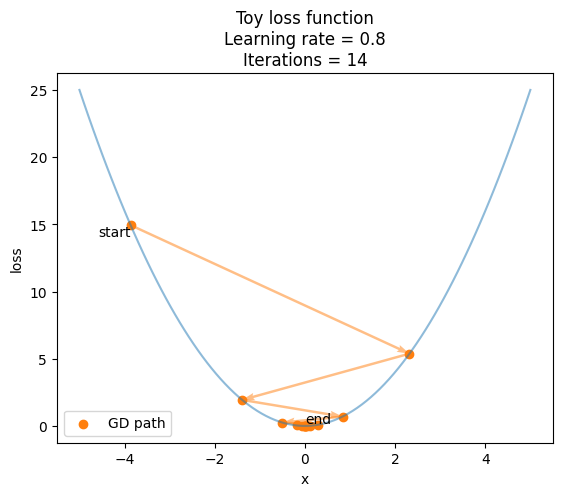

In [20]:
np.random.seed(47)
x_init = np.random.uniform(-5, 5, 1)

# run gradient descent with a learning rate of 0.8
x_hist, n_iter = gd_run(x_init, lr=0.8)

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function\nLearning rate = 0.8\nIterations = {}'.format(n_iter))

Notice how turning the learning rate decreased the number of iterations it took to reach the minimum, but at the cost of causing our path towards that minimum to oscillate. This underscores the importance of *hyperparameters*, such as learning rate, when using machine learning approaches. These often have dramatic impacts whether we are successful in training a decoder.

When would gradient descent fail? Gradient descent will find the minimum loss if the landscape is *convex*. A simple geometric intuition for whether a curve is convex is if you can draw a line between any two points on it, no points on the curve exceed that line.

![Convexity](./images/Convex.svg)

In the diagram above, the non-convex curve has a bump in the middle that prevents us from drawing a line between $a$ and $b$ that is not exceeded by the curve (red shaded region). This is commonly expressed mathematically as Jensen's inequality:
$$ f\left(\frac{a+b}{2}\right)\le\frac{f(a)+f(b)}{2} $$

When a function is non-convex, gradient descent can fail. It may get trapped on its path to the minimum value of the function, known as the global minimum. These points where it gets trapped are known as local minima. We can see all of this was a new toy model. In this case, we will use the quadratic function $ y=0.2x^4 -4x^2 - x$.

Starting point: -3.8651152810635048


Text(0.5, 1.0, 'Non-convex toy loss function\nLearning rate = 0.1\nIterations = 7')

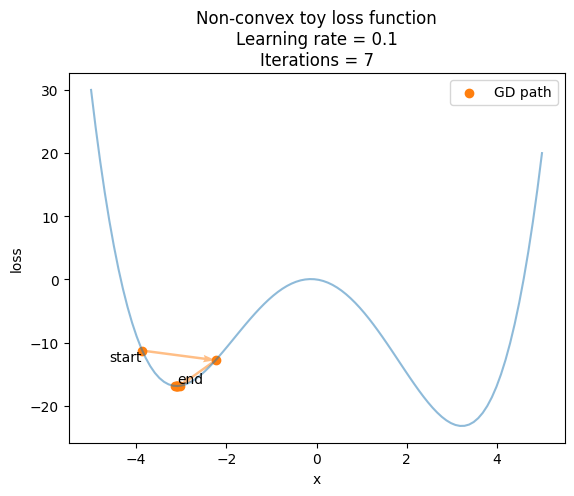

In [21]:
# a non-convex toy loss function
def nc_toy_loss(x):
    return 0.2*x**4 - 4*x**2 - x

# the derivative of the non-convex toy loss function
def nc_toy_loss_derivative(x):
    return 0.8*x**3 - 8*x - 1

# initialize random seed numpy
np.random.seed(47)

# choose our starting point at random
x_hist = np.random.uniform(-5, 5, 1)
print('Starting point:', x_hist[0])
x_hist, n_iter = gd_run(x_init, d_loss=nc_toy_loss_derivative, lr=0.1)

ax = plot_loss(loss=nc_toy_loss)
plot_loss_gd(ax=ax, loss=nc_toy_loss, x_pts=x_hist)
ax.set_title('Non-convex toy loss function\nLearning rate = 0.1\nIterations = {}'.format(n_iter))

If we start our fitting with a negative value of `x`, we get stuck in a valley that is at a higher level than the global minimum. This demonstrates how valuable it is to know whether your loss function is convex. If it is convex, then gradient descent will find the global minimum if run for long enough. 

## Gradient descent for the logistic function

Now that we have defined the loss of the logistic function (eq. 2), and the gradient descent process that optimize over it to find the best combination of parameters, we can write our own function from scratch to fit a logistic model! But before we do that, let's get a little bit more intuition about how the loss landscape for the logistic model behaves.

First, note that the loss function function is the mean loss across all samples in our data set. How does the number of samples influence the loss landscape? We have two parameters were are varying to fit the logistic function, `b` and `w`, so we can plot the loss landscape as an image plot. Our x and y-axes will be the parameters `b` and `w`, respectively, while the color at each point indicates the loss.

Text(0.5, 1.05, 'Cross-entropy loss landscape varies with number of samples')

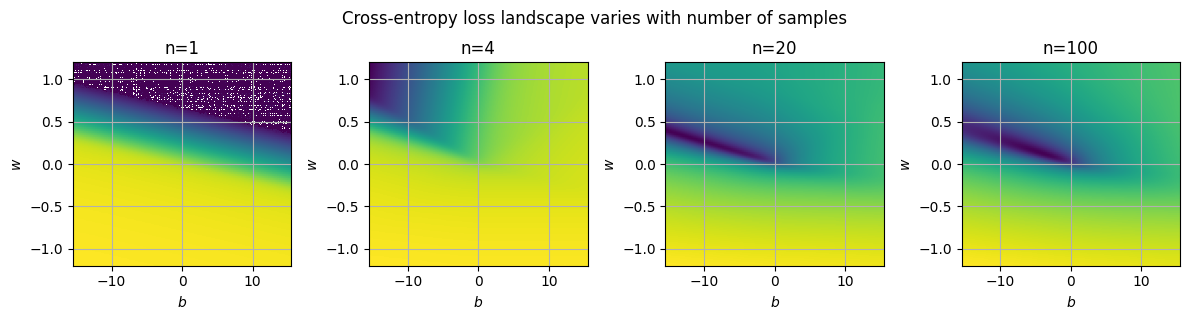

In [23]:
# a function that plots the loss landscape for the logistic model on our data
def plot_logistic_loss_landscape(ax=None, sel_data=None, loss=cross_entropy_loss):
    # Parameters
    # ----------
    # ax : matplotlib axis object, optional
    #     Axis to plot on. If not provided, a new figure and axis will be created.
    # sel_data : array-like, optional
    #     Indices of the data points to use for plotting the loss landscape. If not provided,
    #     all data points will be used.
    # loss : function, optional
    #     Loss function to use. If not provided, cross-entropy loss will be used.
    # Returns
    # -------
    # ax : matplotlib axis object
    #     Axis with the loss landscape plotted.
    # loss_grid : numpy array
    #     Array of loss values for each combination of w and b values.

    if ax is None:
        fig, ax = plt.subplots()
    
    if sel_data is None:
        sel_data = np.arange(0, X.size)
    
    # create a grid of w and b values
    w_grid = np.linspace(-1.2, 1.2, 100)
    b_grid = np.linspace(-15.5, 15.5, 100)
    loss_grid = np.zeros((w_grid.size, b_grid.size))

    # calculate the loss for each combination of w and b values
    for i, w in enumerate(w_grid):
        for j, b in enumerate(b_grid):
            loss_grid[i,j] = loss(y[sel_data], logistic(X.squeeze()[sel_data], w, b))

    # plot the loss landscape
    im = ax.imshow(loss_grid, extent=[b_grid[0], b_grid[-1], w_grid[0], w_grid[-1]],
               norm=colors.LogNorm(), aspect='auto', origin='lower')
    ax.set_xlabel('$b$')
    ax.set_ylabel('$w$')
    ax.grid()
    return ax, loss_grid

# randomize the order of the samples, since the data is ordered
np.random.seed(42)
sel_data = np.random.choice(np.arange(0, X.size), size=X.size, replace=False)

# plot the loss landscape for the logistic model on our data
# using different numbers of samples
fig, ax = plt.subplots(1,4, figsize=(12,3))
for ind, count in enumerate([1, 4, 20, x.size]):
    _, loss_ce = plot_logistic_loss_landscape(ax=ax[ind], sel_data=sel_data[:count])
    ax[ind].set_title('n={}'.format(count))
fig.tight_layout()
fig.suptitle('Cross-entropy loss landscape varies with number of samples', y=1.05)

If we only specify one data point, then the loss landscape is a relatively simple surface that slopes down towards lower values (dark blue) as either `w` or `b` are increased. This is because only one of the samples has to be fit, so as long as the orientation and decision point of our logistic function is set to classify that one data point correctly, our fit will be perfect. When four samples are included, we now have a mixture of trial types, so the logistic model is constrained, we cannot push `w` or `b` towards infinity and still expect perfect performance. A zone starts to emerge with loss minimal for larger values of `w` and negative values of `b`. Further increasing the number of samples creates a well defined valley where loss is minimal.

We chose the cross entropy loss above because of its beneficial properties when working with the Bernoulli probability distribution. However, what if we had gone with another popular loss function, the *mean squared error* (MSE). MSE is the mean difference between our predicted and actual results squared. It is expressed mathematically as:

$$ MSE(y,\hat{y}) = \frac{1}{N}\sum_{i}^{N}(y-\hat{y})^2 $$

This error function is often used when fitting linear systems of equations. If we tried to to use it with our logistic model, what would its loss landscape look like?

Text(0.5, 1.05, 'Mean squared error loss landscape varies with number of samples')

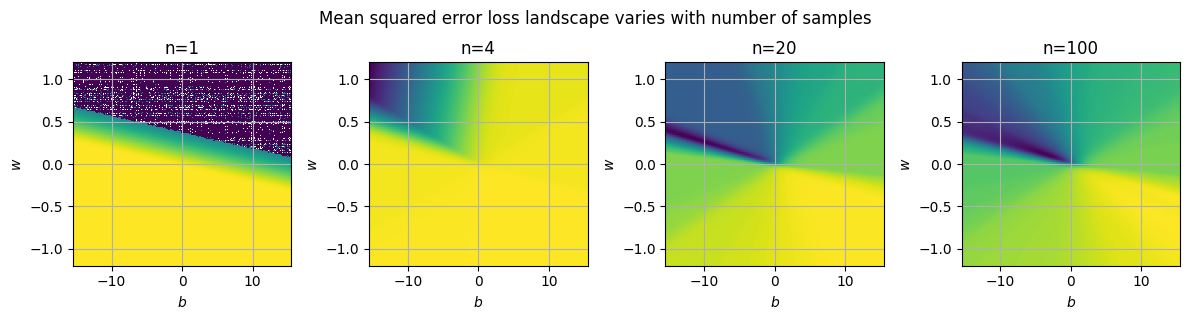

In [24]:
# function for calculating mean squared error loss
def mse_loss(y, y_hat):
    y_hat[y_hat==0] = np.finfo(float).eps # replace 0s with machine epsilon, the smallest possible floating point number
    y_hat[y_hat==1] = 1-np.finfo(float).eps # replace 1s with 1 minus machine epsilon
    return np.mean((y-y_hat)**2)

# plot the loss landscape for the logistic model on our data
# using different numbers of samples and the mean squared error loss
fig, ax = plt.subplots(1,4, figsize=(12,3))
for ind, count in enumerate([1, 4, 20, x.size]):
    _, loss_mse = plot_logistic_loss_landscape(ax=ax[ind], sel_data=sel_data[:count], loss=mse_loss)
    ax[ind].set_title('n={}'.format(count))
fig.tight_layout()
fig.suptitle('Mean squared error loss landscape varies with number of samples', y=1.05)

While the landscapes look broadly similar, there are important differences. Note that as the number of samples increases, the landscape has a faceted appearance, with straight lines running through it. These correspond to edges in the landscape that make it non-convex. This is best visualized by taking a slice of the landscape and comparing it with the same slice from one generated using the cross-entropy loss.

Text(0.5, 1.0, 'Losses along $b=3.1$')

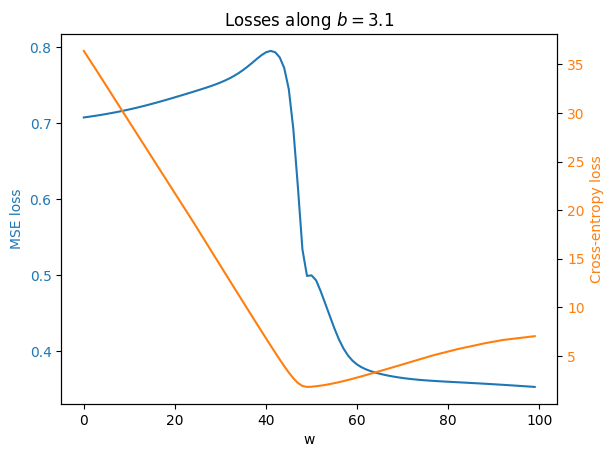

In [29]:
fig, ax = plt.subplots()
ax.plot(loss_mse[:,60])
ax_ce = ax.twinx()
ax_ce.plot(loss_ce[:,60], color='tab:orange')
ax.set_xlabel('w')
ax.set_ylabel('MSE loss', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax_ce.tick_params(axis='y', labelcolor='tab:orange')

ax_ce.set_ylabel('Cross-entropy loss', color='tab:orange')
ax.set_title('Losses along $b=3.1$')

Notice how the cross-entropy loss we use for fitting the logistic model is convex, while the mean squared error loss function is not. This means that gradient descent will work with the cross-entropy loss for a logistic model, but it would not work with the mean squared error loss. 

The reason behind this is that the logistic function on its own is non-convex. This can be demonstrated simply by drawing a line between x=-5 and 5, the logistic function crosses it.

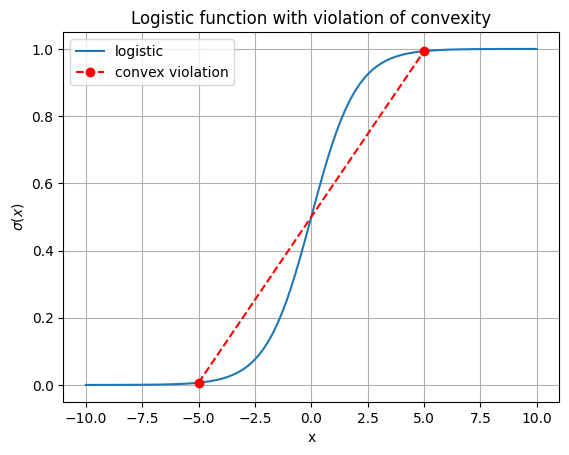

In [37]:
# plot the logistic function
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, logistic(x, 1, 0), label='logistic')
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.grid()

# draw a line between the points on the curve at x = -5 and 5
ax.plot([-5, 5], [logistic(-5, 1, 0), logistic(5, 1, 0)], 'r--', marker='o', label='convex violation')

ax.set_title('Logistic function with violation of convexity')
ax.legend()

What if we passed the logistic function through the cross-entropy loss function? Assuming that the predicted value, $\hat{y}$, is 1, we get:

$$ \begin{align}
    \notag loss &= -ln(\frac{1}{1+e^{-x}})\\
    \notag &= -ln(1) + ln(1+e^{-x})\\
    \end{align}
$$

We can imagine that as $x \to \infty$ the term $e^{-x}$ approaches 0, heading towards $-ln(1)+ln(1)=0$. And, as $x \to -\infty$ the term $ln(1+e^{-x})$ becomes a straight line, since the $1+$ becomes negligble and $ln(e^{-x})=-x$. Let's do some plotting to confirm these intuitions.

(-2.5, 10.0)

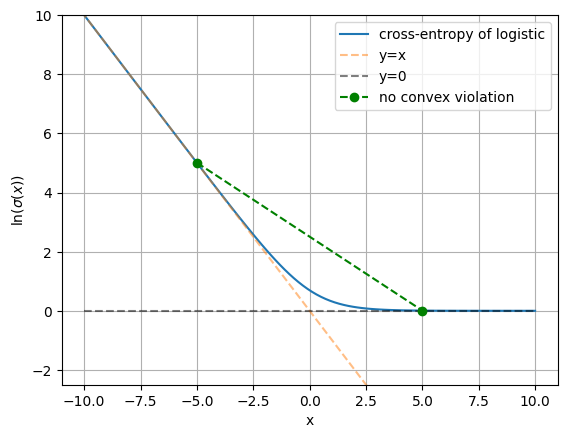

In [57]:
# plot the cross-entropy of the logistic function
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, -np.log(logistic(x, 1, 0)), label='cross-entropy of logistic')
ax.set_xlabel('x')
ax.set_ylabel(r'$\ln(\sigma(x))$')
ax.grid()

# draw a black dotted line for y=-x
ax.plot([10, -10], [-10, 10], '--', label='y=x', alpha=0.5, color='tab:orange')

# draw a black dotted line for y=0
ax.plot([-10, 10], [0, 0], 'k--', label='y=0', alpha=0.5)

# draw a line on the curve between the points -5 and 5
ax.plot([-5, 5], [-np.log(logistic(-5, 1, 0)), -np.log(logistic(5, 1, 0))], 'g--', marker='o', label='no convex violation')

ax.legend()
ax.set_ylim([-2.5, 10])

It is readily apparent that the logistic function when passed through the cross-entropy function is made convex. But recall that the cross-entropy is the average response of our logistic function across all samples. What happens when we add many of these curves together? Fortunately, the addition of any two convex functions results in a new function that is also convex!

Now lets see what happens when we apply the mean squared error loss to the logistic function.

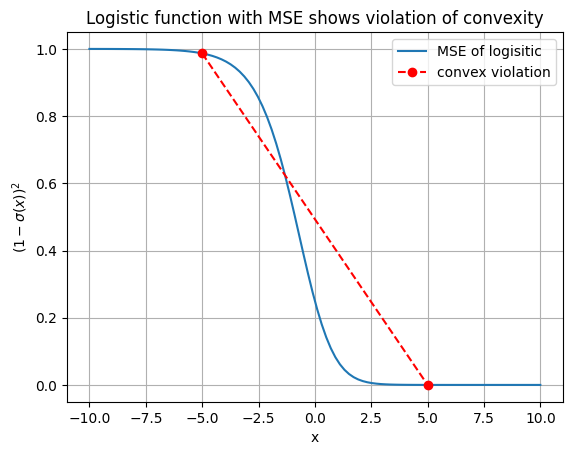

In [56]:
# plot the mean squared error of the logistic function
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, np.power(1-logistic(x, 1, 0),2), label='MSE of logisitic')
ax.set_xlabel('x')
ax.set_ylabel(r'$(1-\sigma(x))^2$')
ax.grid()

# draw a line between the points on the curve at x = -5 and 5
ax.plot([-5, 5], np.power(1-np.array([logistic(-5, 1, 0), logistic(5, 1, 0)]),2), 'r--', marker='o', label='convex violation')

ax.set_title('Logistic function with MSE shows violation of convexity')
ax.legend()

The mean squared error does not transform the logistic function in such a manner as to remove the convexity.

Moving on, to run gradient descent, we need to know the derivative of the cross-entropy loss function for the logistic model (eq. 2). For the logistic model, we have to calculate the derivative for our two parameters, $b$ and $w$. We can grind through the math to get these.

The derivative with respect to $w$ is:
$$ \begin{align}
    \notag \frac{\partial{L}}{\partial{w}}&=\frac{\partial}{\partial{w}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))\\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}1-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))\frac{\partial}{\partial{w}}(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))x \\
    \notag &=-(y-\sigma(wx+b))x \\
    \notag &= (\sigma(wx+b)-y)x \\
\end{align}
$$

And the derivative with respect to $b$ is:
$$ \begin{align}
    \notag \textcolor{lightgray}{\frac{\partial{L}}{\partial{b}}}&\textcolor{lightgray}{=\frac{\partial}{\partial{b}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))}\\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}1-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))}\frac{\partial}{\partial{b}}(wx+b) \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))} \cdot 1 \\
    \notag &=-(y-\sigma(wx+b)) \\
    \notag &= \sigma(wx+b)-y \\
\end{align}
$$

Now that we have all the background and theory under our belt, lets create an object for fitting a logistic model. We will use the same standards as the scikit learn package when designing it.

In [207]:
class LogisticModel():
    def __init__(self, w=0, b=0):
        # Parameters
        # ----------
        # w : float, optional
        #     Initial value for w
        # b : float, optional
        #     Initial value for b

        self.w = w
        self.b = b
        self.w_hist = [w]
        self.b_hist = [b]
        self.loss_hist = []

    def logistic(self, x):
        # Parameters
        # ----------
        # x : array-like
        #     Input data

        # Returns
        # -------
        # y : array-like
        #     Predicted probabilities

        return 1 / (1 + np.exp(-(self.w*x + self.b)))
    
    def derivative_w(self, x, y, y_hat):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values
        # y_hat : array-like
        #     Predicted values
        
        # Returns
        # -------
        # derivative : float
        #     Derivative of the loss with respect to w

        return np.mean((y_hat - y)*x)
    
    def derivative_b(self, y, y_hat):
        # Parameters
        # ----------
        # y : array-like
        #     Target values
        # y_hat : array-like
        #     Predicted values

        # Returns
        # -------
        # derivative : float
        #     Derivative of the loss with respect to b

        return np.mean(y_hat - y)
    
    def cross_entropy_loss(y, y_hat):
        # Parameters
        # ----------
        # y : array-like
        #     Target values
        # y_hat : array-like
        #     Predicted values

        # Returns
        # -------
        # loss : float
        #     Cross-entropy loss

        y_hat[y_hat==0] = np.finfo(float).eps
        y_hat[y_hat==1] = 1-np.finfo(float).eps 
        return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))

    def fit(self, x, y, lr=0.1, tol=0.01, max_iter=100):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values
        # lr : float, optional
        #     Learning rate
        # tol : float, optional
        #     Tolerance for stopping criterion
        # max_iter : int, optional
        #     Maximum number of iterations

        # Returns
        # -------
        # self : LogisticModel
        #     The fitted model

        # initialize the history of w and b values
        self.w_hist = [self.w]
        self.b_hist = [self.b]

        # ensure y and x are formatted as column vectors
        y = y.reshape(-1,1)
        x = x.reshape(-1,1)

        # run gradient descent until the stopping criterion is met
        # or until we reach the maximum number of iterations
        for i in range(max_iter):
            # predict y values using the current w and b values
            y_hat = self.logistic(x)
            self.loss_hist.append(cross_entropy_loss(y, y_hat))

            self.w -= lr*self.derivative_w(x, y, y_hat)
            self.b -= lr*self.derivative_b(y, y_hat)
            
            # add the new w and b values to the history
            self.w_hist.append(self.w)
            self.b_hist.append(self.b)

            # check if the stopping criterion is met
            # if so, break out of the loop
            if (i>0) and (np.abs(self.loss_hist[-1] - self.loss_hist[-2]) < tol):
                break

    def predict(self, x):
        # Parameters
        # ----------
        # x : array-like
        #     Input data

        # Returns
        # -------
        # y_hat : array-like
        #     Predicted probabilities

        return logistic(x, self.w, self.b).ravel()
    
    def score(self, x, y):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values

        # Returns
        # -------
        # score : float
        #     Accuracy of the model

        y_hat = self.predict(x)>=0.5
        return np.mean(y_hat == y)

In [280]:
lm_scratch = LogisticModel()
lm_scratch.fit(X, y, lr=0.015, tol=0.000001, max_iter=2000)
print('Our fitted model parameters: w={:.2f}, b={:.2f}'.format(lm_scratch.w, lm_scratch.b))
print('Scikit learn model parameters: w={:.2f}, b={:.2f}'.format(w_sk, b_sk))
print('Our fitted model score: {:.2f}%'.format(lm_scratch.score(X, y)*100))

Our fitted model parameters: w=0.09, b=-2.45
Scikit learn model parameters: w=0.05, b=-1.86
Our fitted model score: 85.19%


(-8.3, 8.3)

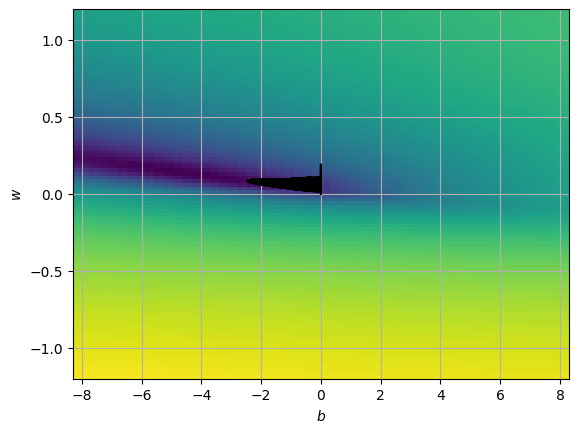

In [281]:
ax,_ = plot_logistic_loss_landscape(sel_data=np.arange(0, X.size))
ax.plot(lm_scratch.b_hist, lm_scratch.w_hist, 'k', label='GD path')
ax.set_xlim([-8.3, 8.3])

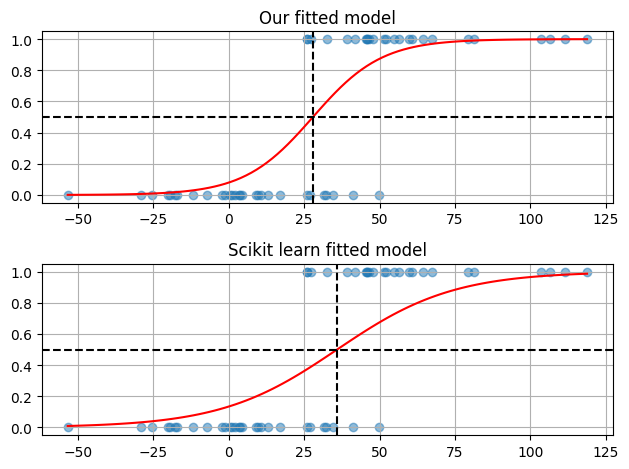

In [282]:
fig, ax = plt.subplots(2,1)
plot_logistic(X, y, lm_scratch.w, lm_scratch.b, ax=ax[0])
# plot sample points colored by their predicted class
y_hat = (lm_scratch.predict(X)>=0.5).ravel()
ax[0].axhline(0.5, color='k', linestyle='--')
ax[0].axvline(-lm_scratch.b/lm_scratch.w, color='k', linestyle='--')
ax[0].set_title('Our fitted model')
plot_logistic(X, y, w_sk, b_sk, ax=ax[1])
ax[1].axhline(0.5, color='k', linestyle='--')
ax[1].axvline(-b_sk/w_sk, color='k', linestyle='--')
ax[1].set_title('Scikit learn fitted model')
fig.tight_layout()


#### Rules for working with logarithms

1. $\log(xy) = \log(x) + \log(y)$
2. $\log\left(\frac{x}{y}\right) = \log(x) - \log(y)$
3. $\log(x^n) = n\log(x)$
4. $\log(1) = 0$
5. $\log(0) = \text{undefined}$